Loaded dataset 1: C3_liquid.csv (119 points)
  Moving average calculated with 12-hour window
Loaded dataset 3: ambient.csv (119 points)
  Moving average calculated with 12-hour window
Loaded dataset 4: soilref.csv (109 points)
  Moving average calculated with 12-hour window
Loaded dataset 6: C3_soil.csv (119 points)
  Moving average calculated with 12-hour window


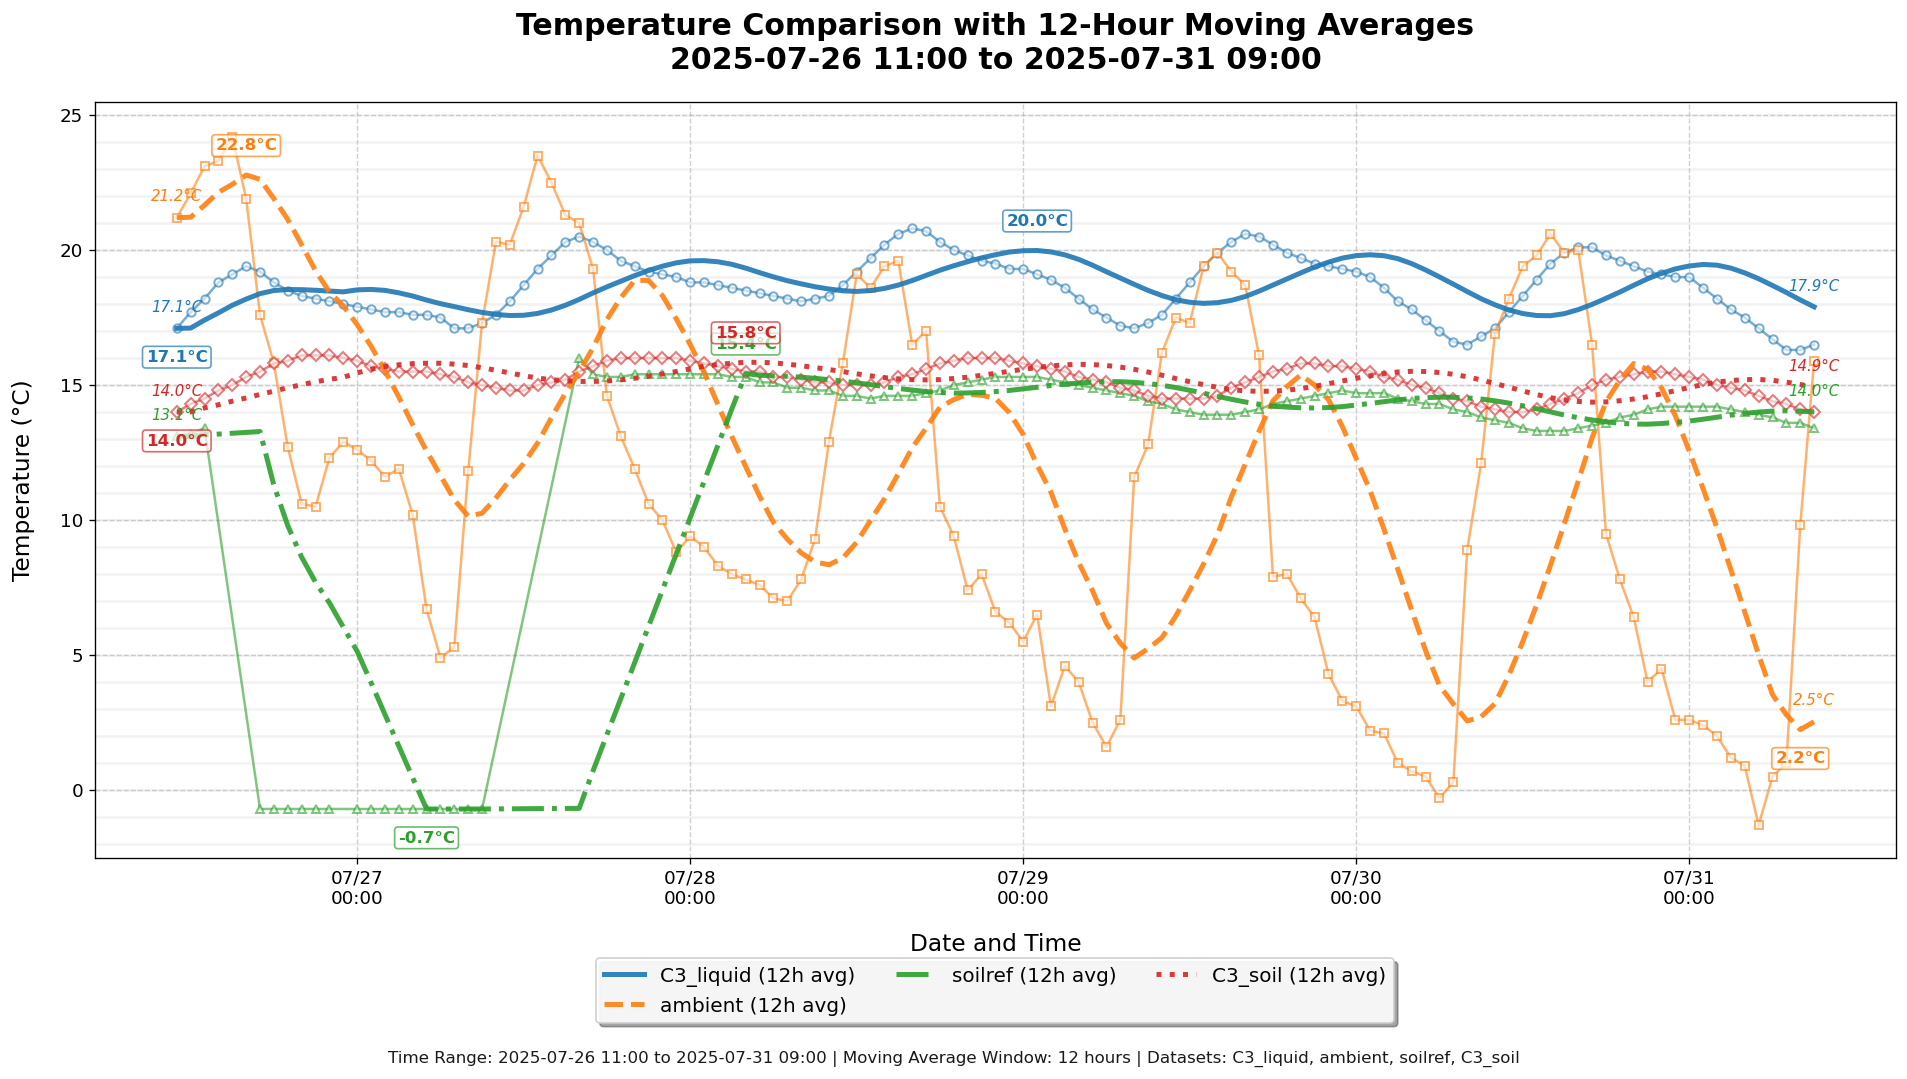


DATA SUMMARY:
Time Range: 2025-07-26 11:00 to 2025-07-31 09:00
Moving Average Window: 12 hours

Dataset 1: C3_liquid
  Original Points: 119
  Original Temp Range: 16.3°C to 20.8°C
  Moving Avg Range: 17.1°C to 20.0°C
  Final Moving Avg: 17.9°C

Dataset 2: ambient
  Original Points: 119
  Original Temp Range: -1.3°C to 24.2°C
  Moving Avg Range: 2.2°C to 22.8°C
  Final Moving Avg: 2.5°C

Dataset 3: soilref
  Original Points: 109
  Original Temp Range: -0.7°C to 16.0°C
  Moving Avg Range: -0.7°C to 15.4°C
  Final Moving Avg: 14.0°C

Dataset 4: C3_soil
  Original Points: 119
  Original Temp Range: 14.0°C to 16.1°C
  Moving Avg Range: 14.0°C to 15.8°C
  Final Moving Avg: 14.9°C


In [1]:
# %% Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import os
from datetime import datetime, timedelta

# %% Parameters (CUSTOMIZE THESE)
# =================================================================================
# Define your 6 dataset paths (update with actual file paths)
FILE_PATHS = [
    "C3_liquid.csv",
    "C3_gas.csv",
    "ambient.csv",
    "soilref.csv",
    "C3_tent.csv",
    "C3_soil.csv"
]

# Set which datasets to plot (True = include, False = exclude)
PLOT_DATASETS = [True, False, True, True, False, True]  # Example: Plot datasets 1, 2 and 5

# Date/time range for filtering
START_DATETIME = "2025-07-26 11:00"  # Start date/time (YYYY-MM-DD HH:MM)
END_DATETIME = "2025-07-31 09:00"    # End date/time (YYYY-MM-DD HH:MM)
# Moving average window (hours)
MOVING_AVG_WINDOW_HOURS = 12
# =================================================================================

# %% Color palette for datasets (up to 6 colors)
COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
MARKERS = ['o', 's', '^', 'D', 'v', 'p']  # Different markers for each dataset
LINE_STYLES = ['-', '--', '-.', ':', '-', '--']  # Line styles for moving averages

# %% Read and process data function
def load_and_process_data(file_path):
    # Read only first three columns
    df = pd.read_csv(
        file_path,
        header=0,
        usecols=[0, 1, 2],
        names=['date_str', 'time_str', 'temperature'],
        dtype={'date_str': str, 'time_str': str}
    )
    
    # Combine date and time columns into datetime
    df['datetime'] = pd.to_datetime(
        df['date_str'] + ' ' + df['time_str'],
        format='%Y.%m.%d %H:%M',
        errors='coerce'
    )
    
    # Convert temperature to numeric, handling errors
    df['temperature'] = pd.to_numeric(df['temperature'], errors='coerce')
    
    # Drop rows with invalid datetime or temperature conversions
    df = df.dropna(subset=['datetime', 'temperature'])
    
    # Set datetime index and sort
    df = df.set_index('datetime').sort_index()
    return df

# Get dataset names from filenames
def get_dataset_name(file_path):
    return os.path.splitext(os.path.basename(file_path))[0]

# Calculate moving average with time-based window
def calculate_moving_average(df, window_hours):
    """Calculate moving average with a time-based window."""
    # Resample to regular frequency (1 minute) to handle irregular data
    resampled = df['temperature'].resample('1T').mean().ffill().bfill()
    
    # Calculate moving average with time-based window
    window_size = f'{window_hours}H'
    moving_avg = resampled.rolling(window=window_size, min_periods=1).mean()
    
    # Return to original timestamps
    return moving_avg.reindex(df.index, method='nearest')

# Load and filter selected datasets
start_dt = pd.to_datetime(START_DATETIME)
end_dt = pd.to_datetime(END_DATETIME)
datasets = []
dataset_names = []
moving_averages = []  # Store moving averages

for i, file_path in enumerate(FILE_PATHS):
    if i < len(PLOT_DATASETS) and PLOT_DATASETS[i]:
        try:
            df = load_and_process_data(file_path)
            filtered = df.loc[start_dt:end_dt]
            if not filtered.empty:
                # Calculate 12-hour moving average
                ma = calculate_moving_average(filtered, MOVING_AVG_WINDOW_HOURS)
                
                datasets.append(filtered)
                moving_averages.append(ma)
                dataset_names.append(get_dataset_name(file_path))
                print(f"Loaded dataset {i+1}: {file_path} ({len(filtered)} points)")
                print(f"  Moving average calculated with {MOVING_AVG_WINDOW_HOURS}-hour window")
            else:
                print(f"Dataset {i+1} has no data in range: {file_path}")
        except Exception as e:
            print(f"Error loading dataset {i+1} ({file_path}): {str(e)}")

if not datasets:
    raise ValueError("No valid datasets to plot! Check your selections and data files.")

# %% Create professional comparison plot
plt.figure(figsize=(16, 9), dpi=120)
ax = plt.gca()

# Plot all selected datasets with moving averages
for i, (df, ma, name) in enumerate(zip(datasets, moving_averages, dataset_names)):
    # Plot original data points
    ax.plot(
        df.index,
        df['temperature'],
        color=COLORS[i],
        linewidth=1.5,
        marker=MARKERS[i],
        markersize=5,
        markerfacecolor='white',
        markeredgewidth=1.2,
        alpha=0.6,
        zorder=2,
        label='_nolegend_'  # Don't show in legend yet
    )
    
    # Plot moving average line
    ax.plot(
        ma.index,
        ma,
        color=COLORS[i],
        linestyle=LINE_STYLES[i],
        linewidth=3,
        alpha=0.9,
        zorder=3,
        label=f"{name} ({MOVING_AVG_WINDOW_HOURS}h avg)"
    )

# Formatting
plt.title(f"Temperature Comparison with {MOVING_AVG_WINDOW_HOURS}-Hour Moving Averages\n"
          f"{start_dt.strftime('%Y-%m-%d %H:%M')} to {end_dt.strftime('%Y-%m-%d %H:%M')}", 
          fontsize=18, pad=20, fontweight='bold')
plt.xlabel("Date and Time", fontsize=14, labelpad=15)
plt.ylabel("Temperature (°C)", fontsize=14, labelpad=15)
plt.grid(True, linestyle='--', alpha=0.6, zorder=1)

# Date formatting
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d\n%H:%M'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=0, ha='center', fontsize=11)

# Set y-axis limits
all_temps = pd.concat([df['temperature'] for df in datasets])
all_ma = pd.concat(moving_averages)
min_temp = np.floor(min(all_temps.min(), all_ma.min())) if not all_temps.empty else 0
max_temp = np.ceil(max(all_temps.max(), all_ma.max())) if not all_temps.empty else 1
plt.ylim(min_temp - 0.5, max_temp + 0.5)
plt.yticks(fontsize=11)

# Add horizontal temperature reference lines
if not all_temps.empty:
    for temp in np.arange(min_temp, max_temp + 1, 1):
        plt.axhline(y=temp, color='gray', linestyle='-', alpha=0.1, zorder=0)

# Add key point annotations for moving averages
def annotate_key_points(ma_series, color, name):
    if len(ma_series) > 0:
        # Start of moving average
        plt.annotate(f"{ma_series.iloc[0]:.1f}°C", 
                     (ma_series.index[0], ma_series.iloc[0]), 
                     textcoords="offset points", 
                     xytext=(0,10), 
                     ha='center',
                     fontsize=9,
                     color=color,
                     fontstyle='italic')
        
        # End of moving average
        plt.annotate(f"{ma_series.iloc[-1]:.1f}°C", 
                     (ma_series.index[-1], ma_series.iloc[-1]), 
                     textcoords="offset points", 
                     xytext=(0,10), 
                     ha='center',
                     fontsize=9,
                     color=color,
                     fontstyle='italic')
        
        # Max moving average
        max_val = ma_series.max()
        max_idx = ma_series.idxmax()
        plt.annotate(f"{max_val:.1f}°C", 
                     (max_idx, max_val), 
                     textcoords="offset points", 
                     xytext=(0,15), 
                     ha='center',
                     fontsize=10,
                     color=color,
                     fontweight='bold',
                     bbox=dict(boxstyle='round,pad=0.2', fc='white', ec=color, alpha=0.7))
        
        # Min moving average
        min_val = ma_series.min()
        min_idx = ma_series.idxmin()
        plt.annotate(f"{min_val:.1f}°C", 
                     (min_idx, min_val), 
                     textcoords="offset points", 
                     xytext=(0,-20), 
                     ha='center',
                     fontsize=10,
                     color=color,
                     fontweight='bold',
                     bbox=dict(boxstyle='round,pad=0.2', fc='white', ec=color, alpha=0.7))

for i, ma in enumerate(moving_averages):
    annotate_key_points(ma, COLORS[i], dataset_names[i])

# Add legend with enhanced styling
legend = plt.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.12),
    ncol=min(3, len(datasets)),
    frameon=True,
    framealpha=0.9,
    shadow=True,
    fancybox=True,
    fontsize=12
)

# Add footer text
selected_count = sum(PLOT_DATASETS)
footer_text = (f"Time Range: {start_dt.strftime('%Y-%m-%d %H:%M')} to {end_dt.strftime('%Y-%m-%d %H:%M')} | "
               f"Moving Average Window: {MOVING_AVG_WINDOW_HOURS} hours | "
               f"Datasets: {', '.join(dataset_names)}")

plt.figtext(0.5, 0.01, footer_text, 
            ha="center", fontsize=10, alpha=0.9)

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # Adjust for legend and footer
plt.show()

# Display data summary
print("\n" + "="*80)
print("DATA SUMMARY:")
print(f"Time Range: {START_DATETIME} to {END_DATETIME}")
print(f"Moving Average Window: {MOVING_AVG_WINDOW_HOURS} hours")
for i, (name, df, ma) in enumerate(zip(dataset_names, datasets, moving_averages)):
    print(f"\nDataset {i+1}: {name}")
    print(f"  Original Points: {len(df)}")
    print(f"  Original Temp Range: {df['temperature'].min():.1f}°C to {df['temperature'].max():.1f}°C")
    print(f"  Moving Avg Range: {ma.min():.1f}°C to {ma.max():.1f}°C")
    print(f"  Final Moving Avg: {ma.iloc[-1]:.1f}°C")
print("="*80)